In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import CoolProp.CoolProp as cp
import pandas as pd
import scipy

In [21]:
#Constants
molar_mass_water = 18.01528e-3  # [kg/mol]
Tc = cp.PropsSI('T_critical', 'water')  # [K]
temp_arr = np.arange(274, 648) #[K]

### 2a

Vi importerer eksperimentell data fra excel ark ved hjelp av pandas sin `pd.read_excel`. Den tar inn blant annet en path til filen, hvilket ark i filen den skal lese fra og om den har en tittel.

In [22]:
dataVV = pd.read_excel(r'C:\Git\TMA4320\tekfys-prosjekt\WaterVolume.xlsx', sheet_name="Vv", header=None) #V_v [cm^3/g]
#Source: https://www.engineeringtoolbox.com/water-specific-volume-weight-d_661.html
dataTVV = pd.read_excel(r'C:\Git\TMA4320\tekfys-prosjekt\WaterVolume.xlsx', sheet_name="T_vv", header=None) #T [Celsius]
#Source: https://www.engineeringtoolbox.com/water-specific-volume-weight-d_661.html
dataL = pd.read_excel(r'C:\Git\TMA4320\tekfys-prosjekt\WaterVolume.xlsx', sheet_name="L", header=None) #L [kJ/kg]
#Source: https://www.engineeringtoolbox.com/water-properties-d_1573.html
dataTL = pd.read_excel(r'C:\Git\TMA4320\tekfys-prosjekt\WaterVolume.xlsx', sheet_name="T", header=None) #T [Celsius]
#Source: https://www.engineeringtoolbox.com/water-properties-d_1573.html
dataVg = pd.read_excel(r'C:\Git\TMA4320\tekfys-prosjekt\WaterVolume.xlsx', sheet_name="Vg", header=None) #V_g [g/L]
#Source: https://www.engineeringtoolbox.com/water-properties-temperature-equilibrium-pressure-d_2099.html
dataTg = pd.read_excel(r'C:\Git\TMA4320\tekfys-prosjekt\WaterVolume.xlsx', sheet_name="Tg", header=None) #T_g [K]
#Source: https://www.engineeringtoolbox.com/water-properties-temperature-equilibrium-pressure-d_2099.html


In [23]:
#Convert to np.ndarray 
Vv_ = dataVV.to_numpy(dtype=float).reshape(37)
T_Vv = dataTVV.to_numpy(dtype=float).reshape(37)
L_ = dataL.to_numpy(dtype=float).reshape(35)
T_L = dataTL.to_numpy(dtype=float).reshape(35)
Vg_ = dataVg.to_numpy(dtype=float).reshape(20)
Tg_exp = dataTg.to_numpy(dtype=float).reshape(20)

#Konverter til Kelvin
T_L_exp = T_L + 273.15
T_Vv_exp = T_Vv + 273.15
#Konverter til L
Vv_exp = Vv_ * molar_mass_water
Vg_exp = molar_mass_water*1.0E3/Vg_
#Konverter til J
L_exp = molar_mass_water*1.0E3*L_

### 2b

For å finne en regresjonslinje til den eksperimentelle dataen, kan vi bruke `scipy.optimize.curve_fit`. Modellene vi sender inn for $V_v$ og $V_g$ har vi funnet ved å teste ulike funksjonstyper og se hva som passer best. Modellen for $L$ kommer fra Clayperons likning, der vi kan se at $L$ er proporsjonal med $T$. Best mulig proporsjonalitet er videre funnet ved å prøve og feile. 

In [24]:
#Modeller for regresjon
def modelVv(x, a, b, c, d):
    return a*x**6 + b*x**4 + c*x**2 + d

def modelVg(x, a, b):
    return a*np.exp(b/x)

def modelL(x, a, b):
    return b*(np.abs(x-Tc))**a  

In [25]:
#Henter ut koeffisientene som skal inn som parametere i modellfunksjonene
paramsVV, _ = scipy.optimize.curve_fit(modelVv, T_Vv_exp, Vv_exp)
paramsVG, _ = scipy.optimize.curve_fit(modelVg, Tg_exp, Vg_exp)
paramsL, _ = scipy.optimize.curve_fit(modelL, T_L_exp, L_exp)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23512\2136660678.py:9: RuntimeWarning: divide by zero encountered in power
  return b*(np.abs(x-Tc))**a


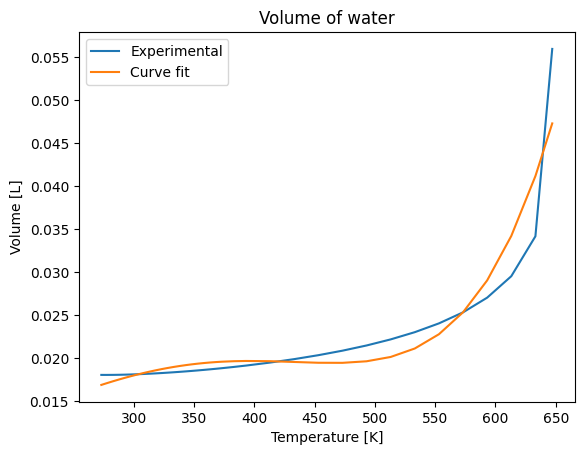

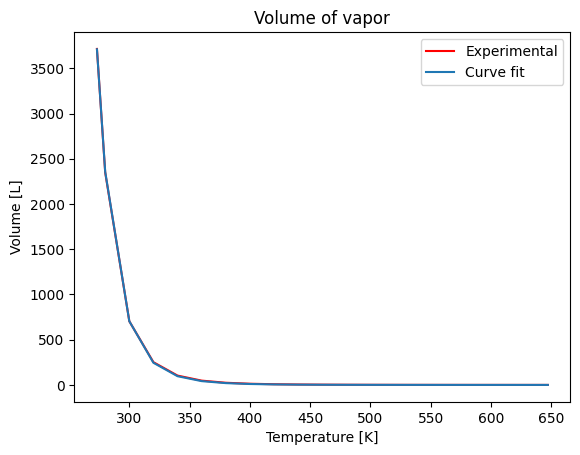

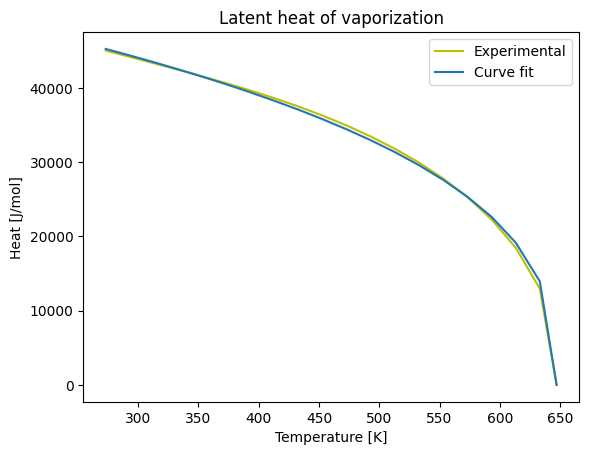

In [26]:
#Plotter spesifikt volum av vann som funksjon av temperatur
plt.plot(T_Vv_exp, Vv_exp, label="Experimental")
plt.plot(T_Vv_exp, modelVv(T_Vv_exp, *paramsVV), label="Curve fit")
plt.title("Volume of water")
plt.xlabel("Temperature [K]")
plt.ylabel("Volume [L]")
plt.legend()
plt.show()

#Plotter spesifikt volum av vanndamp som funksjon av temperatur
plt.plot(Tg_exp, Vg_exp, label="Experimental", color='r')
plt.plot(Tg_exp, modelVg(Tg_exp, *paramsVG), label="Curve fit")
plt.title("Volume of vapor")
plt.xlabel("Temperature [K]")
plt.ylabel("Volume [L]")
plt.legend()
plt.show()

#Plotter fordampningsvarme som funksjon av temperatur
plt.plot(T_L_exp, L_exp, label="Experimental", color='y')
plt.plot(T_L_exp, modelL(T_L_exp, *paramsL), label="Curve fit")
plt.title("Latent heat of vaporization")
plt.xlabel("Temperature [K]")
plt.ylabel("Heat [J/mol]")
plt.legend()
plt.show()

### 2c

Vi ønsker nå å integrere likning (13) ved hjelp av Simpsons metode. Vi starter med å definere en funksjon for å kunne integrere.

In [27]:
def simpsons(x, f):
    """ 
    Integrates by Simpsons rule.
    
    Parameters:
    x : np.ndarray (n)
        Array of x-values (independent variable)
    f : callable
        Callable function to integrate.
    a : float
        Startvalue to integrate from
    b : float
        Endvalue to integrate to

    Returns:
    sol : np.ndarray (n)
        Array of integrated solution
    """
    n = len(x)
    h = (x[-1]-x[0])/(n-1)
    sol = (h/3) * (f(x[0]) + 2*np.sum(f(x[:n-2:2])) + 4*np.sum(f(x[1:n-1:2])) + f(x[n-1]))
    return sol


ValueError: x and y must have same first dimension, but have shapes (374,) and (1,)

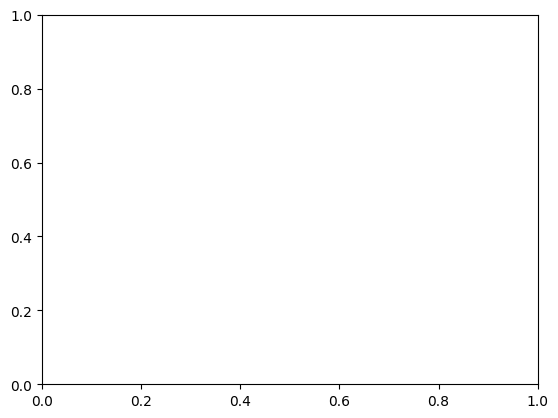

In [30]:
def dp(x):
    return modelL(x, *paramsL) / (x * (modelVg(x, *paramsVG) - modelVv(x, *paramsVV)))

p_clapeyron = simpsons(temp_arr, dp)

p = [simpsons(t, t0=274, dp) for t in temp_arr]

plt.plot(temp_arr, p_clapeyron, label="simpsons løsning")
plt.legend()
plt.show()